In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the dataset
data_path = '/content/drive/MyDrive/fz-fyp-new/cleaned_wind_data.csv'
data = pd.read_csv(data_path, parse_dates=['Date/Time'])
data.sort_values(by='Date/Time', inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
# Feature Engineering (replicating notebook steps)
data['Power_Tplus30'] = data['LV ActivePower (kW)'].shift(-3)
data['Power_lag1'] = data['LV ActivePower (kW)'].shift(1)
data['Power_lag2'] = data['LV ActivePower (kW)'].shift(2)
data['Power_lag3'] = data['LV ActivePower (kW)'].shift(3)
data['WindSpeed_lag1'] = data['Wind Speed (m/s)'].shift(1)
data['WindSpeed_lag2'] = data['Wind Speed (m/s)'].shift(2)
data['WindSpeed_lag3'] = data['Wind Speed (m/s)'].shift(3)
data['WindSpeed_rolling_mean_3'] = data['Wind Speed (m/s)'].rolling(window=3).mean()
data['Power_rolling_mean_3'] = data['LV ActivePower (kW)'].rolling(window=3).mean()
data['wd_sin'] = np.sin(np.radians(data['Wind Direction (°)']))
data['wd_cos'] = np.cos(np.radians(data['Wind Direction (°)']))
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
data.dropna(inplace=True)


In [8]:
# Train-test split
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [9]:
# Define features for XGBoost and LightGBM
features = [
    'Power_lag1', 'Power_lag2', 'Power_lag3',
    'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
    'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3',
    'wd_sin', 'wd_cos', 'Hour_sin', 'Hour_cos',
    'Month_sin', 'Month_cos'
]
X_test = test_data[features]
y_test = test_data['Power_Tplus30']

In [10]:
# Define features for LSTM and GRU
feature_cols = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'wd_sin', 'wd_cos']
window_size = 3

def create_sequences(features, target, window_size=3):
    X_seq, y_seq = [], []
    for i in range(len(features) - window_size):
        seq_x = features[i:i+window_size]
        seq_y = target[i+window_size]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

test_features = test_data[feature_cols].values
test_target = test_data['Power_Tplus30'].values
X_test_seq, y_test_seq = create_sequences(test_features, test_target, window_size)

In [11]:
# Model paths
model_paths = {
    'ARIMA': '/content/drive/MyDrive/fz-fyp-new/track 1/arima/best_arima_model.pkl',
    'XGBoost': '/content/drive/MyDrive/fz-fyp-new/track 1/xgboost/best_xgboost_model.pkl',
    'LightGBM': '/content/drive/MyDrive/fz-fyp-new/track 1/lightgbm/best_lightgbm_model.pkl',
    'LSTM': '/content/drive/MyDrive/fz-fyp-new/track 1/lstm/lstm_model_tuned.h5',
    'GRU': '/content/drive/MyDrive/fz-fyp-new/track 1/gru_tuned/gru_tuned_model.h5',
    'Tuned XGBoost': '/content/drive/MyDrive/fz-fyp-new/track 1/xgboost/xg_tuned.pkl'
}

In [12]:
# Initialize predictions and metrics
predictions = {}
metrics = []


In [13]:
# Load and predict for each model
for model_name, model_path in model_paths.items():
    if os.path.exists(model_path):
        try:
            if model_name == 'ARIMA':
                model = joblib.load(model_path)
                y_pred = model.forecast(steps=len(y_test))
                predictions[model_name] = y_pred
            elif model_name in ['LSTM', 'GRU']:
                model = tf.keras.models.load_model(model_path)
                y_pred = model.predict(X_test_seq, verbose=0).flatten()
                predictions[model_name] = y_pred
                y_test_temp = y_test_seq  # Use sequenced test target
            else:  # XGBoost, LightGBM, Tuned XGBoost
                model = joblib.load(model_path)
                y_pred = model.predict(X_test)
                predictions[model_name] = y_pred
                y_test_temp = y_test

            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_test_temp, y_pred))
            mae = mean_absolute_error(y_test_temp, y_pred)
            r2 = r2_score(y_test_temp, y_pred)
            metrics.append({'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R²': r2})
            print(f"Evaluated {model_name}")
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
    else:
        print(f"Model file not found: {model_path}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Error evaluating ARIMA: name 'y_test_temp' is not defined


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:52:05] WARNING: /workspace/src/gbm/gbtree.cc:363: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:52:05] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:52:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserW

Evaluated XGBoost
Evaluated LightGBM
Error evaluating LSTM: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Error evaluating GRU: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Evaluated Tuned XGBoost


In [14]:
# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

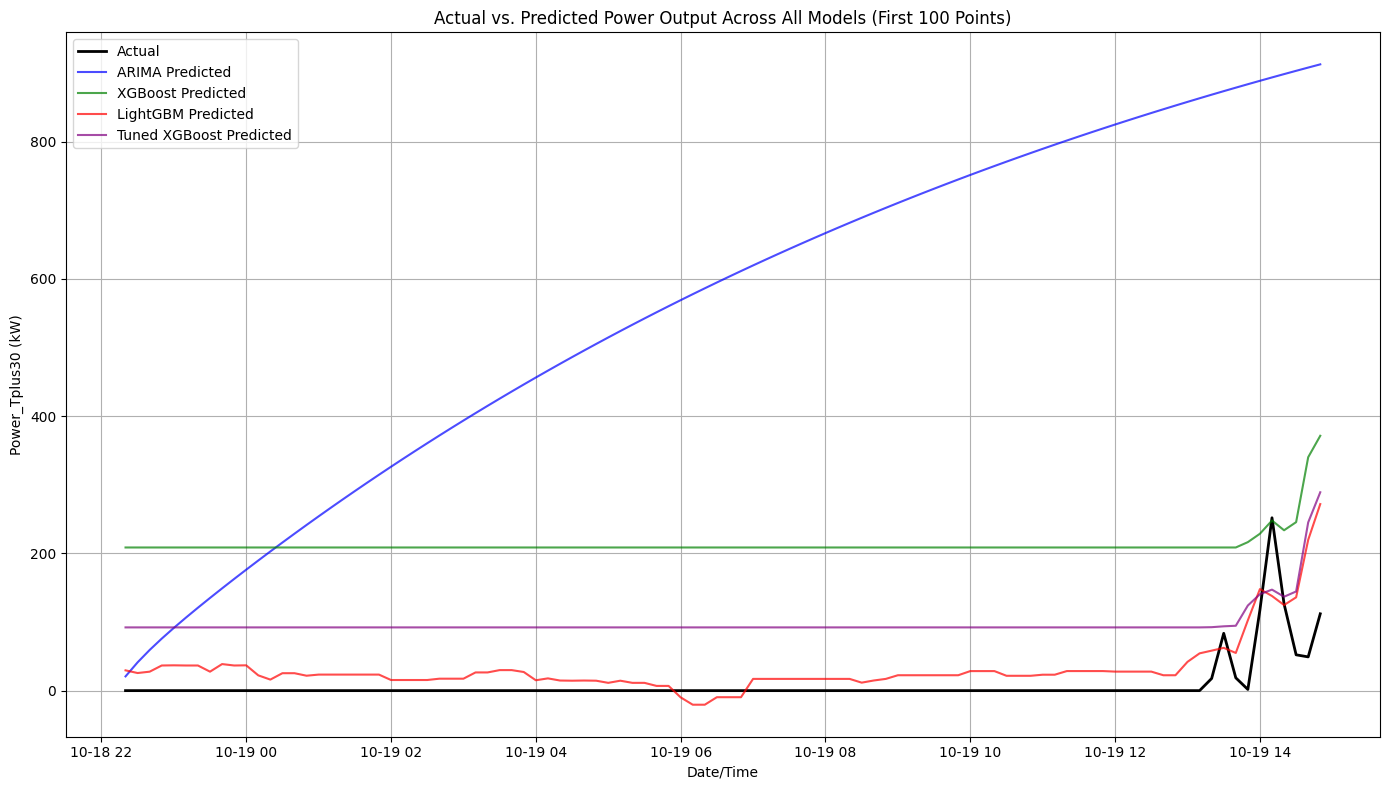

In [18]:
# Time-Series Plot for a Subset (first 100 points for clarity)
subset_size = 100
plt.figure(figsize=(14, 8))
plt.plot(test_data['Date/Time'][:subset_size], y_test[:subset_size], label='Actual', color='black', linewidth=2)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']
for idx, (model_name, y_pred) in enumerate(predictions.items()):
    if model_name in ['LSTM', 'GRU']:
        # Adjust for sequence-based models
        plt.plot(test_data['Date/Time'][window_size:window_size+subset_size],
                 y_pred[:subset_size],
                 label=f'{model_name} Predicted',
                 color=colors[idx % len(colors)], alpha=0.7)
    else:
        plt.plot(test_data['Date/Time'][:subset_size],
                 y_pred[:subset_size],
                 label=f'{model_name} Predicted',
                 color=colors[idx % len(colors)], alpha=0.7)
plt.xlabel('Date/Time')
plt.ylabel('Power_Tplus30 (kW)')
plt.title('Actual vs. Predicted Power Output Across All Models (First 100 Points)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('all_models_time_series_comparison.png')
plt.show()
plt.close()

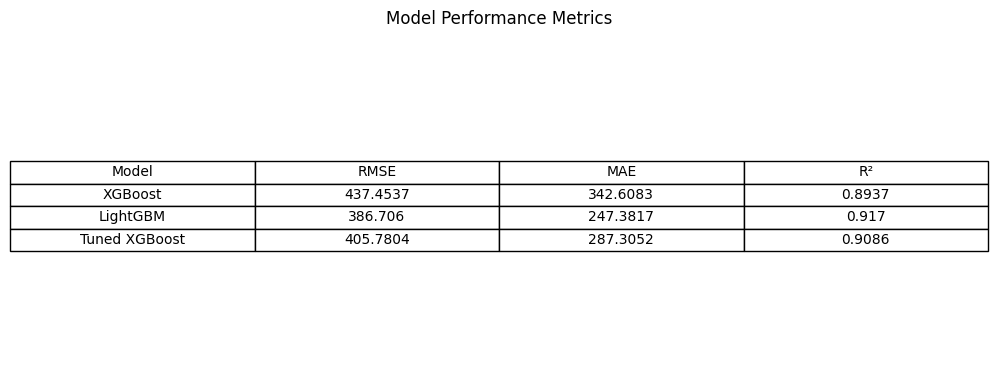

Visualizations saved as 'all_models_time_series_comparison.png' and 'all_models_metrics_table.png'
Metrics Summary:
           Model      RMSE       MAE      R²
0        XGBoost  437.4537  342.6083  0.8937
1       LightGBM  386.7060  247.3817  0.9170
2  Tuned XGBoost  405.7804  287.3052  0.9086


In [17]:
# Metrics Table Visualization
plt.figure(figsize=(10, 4))
plt.axis('off')
table = plt.table(cellText=metrics_df.round(4).values,
                  colLabels=metrics_df.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Model Performance Metrics')
plt.tight_layout()
plt.savefig('all_models_metrics_table.png')
plt.show()
plt.close()

print("Visualizations saved as 'all_models_time_series_comparison.png' and 'all_models_metrics_table.png'")
print("Metrics Summary:")
print(metrics_df.round(4))